In [115]:
import os
import keras
import keras.backend as K
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model

from data import read_crop_list, load_structured_sample
from eval import eval_model_one_hot
from metrics import f1, f1_loss
from models import model_stack_lstm, model_Conv1D, model_Conv1D_LSTM
from training import train, create_training_folder
from keras.utils import plot_model
from training import train, create_training_folder, create_callbacks, step_decay_exp


from keras.models import Sequential
from tensorflow.python.keras.layers import concatenate, Embedding, LSTM, BatchNormalization, Dense, Conv1D, GlobalAveragePooling1D, \
    Dropout, Input, Permute, Concatenate, GlobalMaxPooling1D, MaxPooling1D, Flatten, Activation, Reshape


from training import train, create_training_folder


In [2]:
def load_model(file_name):
    loaded_model = keras.models.load_model(file_name)
    return loaded_model

In [3]:
from training import train, create_training_folder

tf.keras.utils.get_custom_objects()
tf.keras.utils.get_custom_objects()['f1'] = f1
tf.keras.utils.get_custom_objects()['f1_loss'] = f1_loss

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [4]:

df_crops, vocab = read_crop_list()

sample = load_structured_sample()
# sample = load_undersampled_data()
print("Using sample size: {}".format(sample.shape))

y = sample[:, 8]
X = sample[:, 0:8]
sequence_length = X.shape[-1]

# X = one_hot_encoding_X(X, vocab_size=vocab_size)
y = to_categorical(y)
# random train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# y_train = to_categorical(y_train, num_classes=vocab_size)
# y_test = to_categorical(y_test, num_classes=vocab_size)

print(np.unique(y_train).shape)

print("===Train/test size: {}, {}".format(len(y_train), len(y_test)))

Using sample size: (31015, 9)
(2,)
===Train/test size: 21710, 9305


In [5]:
X.shape

(31015, 8)

In [6]:
crop_names = df_crops["description"].values.tolist()
crop_list = df_crops["code"].values.tolist()

In [7]:
np.unique(X)
np.unique(y)

df_crops

# model = load_model('../results/20200719_181629_lstm_64_64')


,code,description,is_crop
0,1,TRIGO,1
1,3,URBANO-VIALES,0
2,4,MAIZ,1
3,5,CEBADA,1
4,8,OTROS CEREALES,1
5,9,ROQUEDOS,0
6,20,SUELO DESNUDO,1
7,33,GIRASOL,1
8,35,COLZA,1
9,39,OTRAS LEGUMINOSAS GRANO,1


In [8]:
# y_pred = model.predict(X_test)

# class_test = np.argmax(y_test, axis=1)
# class_predicted = np.argmax(y_pred,crop_names axis=1)

# # eval_model(folder, class_predicted, class_test, classes, labels)
# np.unique(class_predicted)

In [137]:
def model_Conv1D(sequence_length, embeddings):
    vocab_size, embedding_size = embeddings
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_size,
                        input_length=sequence_length))
    model.add(Conv1D(filters=32, kernel_size=2, strides=1, activation='relu'))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=32, kernel_size=5, strides=1, activation='relu'))
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(MaxPooling1D(4))
# #     model.add(Dropout(0.5))
#     model.add(GlobalMaxPooling1D())
#     model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(Dense(vocab_size, activation='relu'))
    model.add(Dense(vocab_size, activation='relu'))
    return model

def model_Rest_Stacked_lstm(sequence_length, embeddings):
    vocab_size, embedding_size = embeddings

    input = Input(shape=(sequence_length,))
    embeddings = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)

    conv1 = Conv1D(filters=128, kernel_size=2, padding="same", strides=1, activation='relu')(embeddings)
    conv2 = Conv1D(filters=128, kernel_size=4, padding="same", strides=1, activation='relu')(embeddings)
    # # conv3 = Conv1D(filters=32, kernel_size=7, padding="same", strides=1, activation='relu')(embeddings)
#     lstm1 = LSTM(64, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(embeddings)

    concat = Concatenate(axis=2)([conv1, conv2, embeddings])
    concat = Dropout(0.3)(concat)
    lstm2 = LSTM(64, dropout=0.3, recurrent_dropout=0.2)(concat)

    btch = BatchNormalization()(lstm2)
    output = Dense(vocab_size, activation='relu')(btch)
    # output = concat
    model = Model(input, output, name="conv-lstm_parallel")
    # tag = "conv_lstm_restnet"
    return model    


def hydrid(sequence_length, embeddings):
    vocab_size, embedding_size = embeddings

    input = Input(shape=(sequence_length,))
    embeddings1 = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)

    input2 = Input(shape=(sequence_length,))
    embeddings2 = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)

    input3 = Input(shape=(sequence_length,))
    embeddings3 = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)

    # conv
    conv1 = Conv1D(filters=64, kernel_size=3, padding="same", strides=1, activation='relu')(embeddings1)
    conv2 = Conv1D(filters=66, kernel_size=4, padding="same", strides=1, activation='relu')(embeddings2)
    lstm = LSTM(128, dropout=0.3, recurrent_dropout=0.4, return_sequences=True)(embeddings3)
    # # conv3 = Conv1D(filters=32, kernel_size=7, padding="same", strides=1, activation='relu')(embeddings)

    concat = Concatenate(axis=2)([conv1, conv2, lstm])
    
#     concat = Dropout(0.3)(concat)
    lstm2 = LSTM(128, dropout=0.3, recurrent_dropout=0.4)(concat)

    btch = BatchNormalization()(lstm2)
    output = Dense(vocab_size, activation='relu')(btch)
    # output = concat
    model = Model(input, output, name="conv-lstm_parallel")
    # tag = "conv_lstm_restnet"
    return model   

def basic_lstm(sequence_length, embeddings):
    input = Input(shape=(sequence_length,))
    embeddings = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)
    lstm = LSTM(128, dropout=0.3, recurrent_dropout=0.5)(embeddings)
    btch = BatchNormalization()(lstm)
    output = Dense(vocab_size, activation='relu')(btch)
    # output = concat
    model = Model(input, output)
    # tag = "conv_lstm_restnet"
    return model   


def lstm_conv(sequence_length, embeddings):
    vocab_size, embedding_size = embeddings

    input = Input(shape=(sequence_length,))
    embeddings1 = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)

    input2 = Input(shape=(sequence_length,))
    embeddings2 = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)

    input3 = Input(shape=(sequence_length,))
    embeddings3 = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)

    # conv
#     conv1 = Conv1D(filters=64, kernel_size=3, padding="same", strides=1, activation='relu')(embeddings1)
# #     conv1 = Flatten()(conv1)
    conv2 = Conv1D(filters=64, kernel_size=3, padding="same", strides=1, activation='relu')(embeddings2)
    conv2 = Dense(8)(conv2)
    lstm = LSTM(128, dropout=0.3, recurrent_dropout=0.4, return_sequences=True)(embeddings3)
    # # conv3 = Conv1D(filters=32, kernel_size=7, padding="same", strides=1, activation='relu')(embeddings)

    concat = Concatenate(axis=2)([conv2, lstm])
    
#     concat = Dropout(0.3)(concat)
    dense = Dense(512, activation='relu')(concat)
    flatten = Flatten()(dense)
#     btch = BatchNormalization()(dense)
    output = Dense(vocab_size, activation='relu')(flatten)
    # output = concat
    model = Model(input, output, name="conv-lstm_parallel")
    # tag = "conv_lstm_restnet"
    return model   


def basic_lstm_conv(sequence_length, embeddings):
    input = Input(shape=(sequence_length,))
    
    embeddings = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)
    lstm = LSTM(128, dropout=0.3, recurrent_dropout=0.5, return_sequences=True)(embeddings)
#     btch = BatchNormalization()(lstm)
    conv = Conv1D(filters=64, kernel_size=3, padding="same", strides=1, activation='relu')(lstm)
#     conv = BatchNormalization()(lstm)
    flatten = Flatten()(conv)

    output = Dense(vocab_size, activation='relu')(flatten)
    
    model = Model(input, output)
    # tag = "conv_lstm_restnet"
    return model   



from tensorflow.python.keras.regularizers import l2
def lstmfcn(sequence_length, embeddings, layer_size = 64):
    vocab_size, embedding_size = embeddings

    input = Input(shape=(sequence_length,))

    x = Embedding(vocab_size, embedding_size,input_length=sequence_length)(input)
    x_conv = Conv1D(filters=32, kernel_size=3, padding="same", strides=1, activation='relu')(x)
    x = Concatenate(axis=2)([x, x_conv])
    x = LSTM(128, recurrent_dropout=0.4, recurrent_regularizer=l2(0.001))(x)  # lstm block
    x = Dropout(0.5)(x)

    # permutes the first and second dimension of the input (connecting RNNs and convnets together)
    y = Embedding(vocab_size, 27,input_length=sequence_length)(input)
    y = Permute((2, 1))(y)

    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)  # for temporal convolution
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(0.5)(y)
    
    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    out = Dense(vocab_size, activation='relu')(x)  # classification

    model = Model(input, out)
    model.summary()

    return model

def fcn(sequence_length, embeddings, layer_size = 64):
    vocab_size, embedding_size = embeddings

    input = Input(shape=(sequence_length,))

    # permutes the first and second dimension of the input (connecting RNNs and convnets together)
    y = Embedding(vocab_size, embedding_size,input_length=sequence_length)(input)
    y = Permute((2, 1))(y)

    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)  # for temporal convolution
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(0.5)(y)
    
    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)

    out = Dense(vocab_size, activation='relu')(y)  # classification

    model = Model(input, out)
    model.summary()

    return model


def basic_lstm_flatten(sequence_length, embeddings):
    input = Input(shape=(sequence_length,))
    embeddings = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)
    embeddings = Flatten()(embeddings)
    embeddings = Reshape((-1, embedding_size))(embeddings)
    lstm = LSTM(128, dropout=0.3, recurrent_dropout=0.5)(embeddings)
    btch = BatchNormalization()(lstm)
    output = Dense(vocab_size, activation='relu')(btch)
    # output = concat
    model = Model(input, output)
    # tag = "conv_lstm_restnet"
    return model   

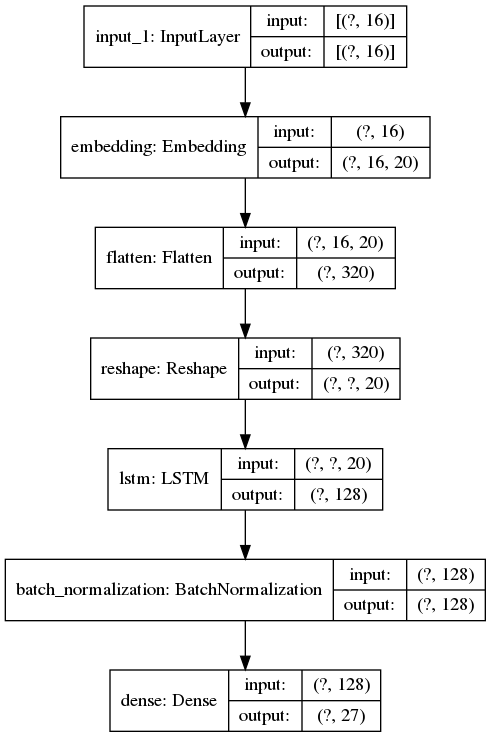

In [138]:

K.clear_session()
sequence_length = 16
vocab_size, embedding_size = (27, 20)
# model = hydrid(sequence_length, (vocab_size, embedding_size))
model = basic_lstm_flatten(sequence_length, (vocab_size, embedding_size))

tag = "conv_rest_stacked"

plot_model(model, show_shapes = True)

In [ ]:


# sequence_length = 8

# vocab_size, embedding_size = (28, 5)
# layer_size = (64, 32)
# final_activation = "relu"

# model = Sequential()
# model.add(Embedding(vocab_size, embedding_size,
#                     input_length=sequence_length))
# return_sequences = True
# for i, units in enumerate(layer_size):
#     if i == len(layer_size) - 1:  # last layer
#         return_sequences = False
#     model.add(LSTM(units, dropout=0.3, recurrent_dropout=0.4,
#                    activation='relu', return_sequences=return_sequences))
# model.add(BatchNormalization())
# model.add(Dense(vocab_size, activation=final_activation))
# tag = "conv_lstm_128_64"

Epoch 1/100

Epoch 00001: val_f1 improved from -inf to 0.55300, saving model to /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200724_131446_conv_rest_stacked
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200724_131446_conv_rest_stacked/assets
679/679 - 9s - loss: 0.5366 - f1: 0.4706 - val_loss: 0.4477 - val_f1: 0.5530
Epoch 2/100

Epoch 00002: val_f1 improved from 0.55300 to 0.60076, saving model to /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200724_131446_conv_rest_stacked
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200724_131446_conv_rest_stacked/assets
679/679 - 8s - loss: 0.4216 - f1: 0.5788 - val_loss: 0.3991 - val_f1: 0.6008
Epoch 3/100

Epoch 00003: val_f1 improved from 0.60076 to 0.63195, saving model to /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200724_131446_conv_rest_stacked
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200

679/679 - 8s - loss: 0.2619 - f1: 0.7378 - val_loss: 0.2758 - val_f1: 0.7240
Epoch 27/100

Epoch 00027: val_f1 did not improve from 0.72403
679/679 - 6s - loss: 0.2554 - f1: 0.7443 - val_loss: 0.2783 - val_f1: 0.7215
Epoch 28/100

Epoch 00028: val_f1 did not improve from 0.72403
679/679 - 6s - loss: 0.2536 - f1: 0.7462 - val_loss: 0.2763 - val_f1: 0.7235
Epoch 29/100

Epoch 00029: val_f1 did not improve from 0.72403
679/679 - 7s - loss: 0.2493 - f1: 0.7503 - val_loss: 0.2801 - val_f1: 0.7195
Epoch 30/100

Epoch 00030: val_f1 improved from 0.72403 to 0.72450, saving model to /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200724_131446_conv_rest_stacked
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200724_131446_conv_rest_stacked/assets
679/679 - 8s - loss: 0.2562 - f1: 0.7434 - val_loss: 0.2752 - val_f1: 0.7245
Epoch 31/100

Epoch 00031: val_f1 did not improve from 0.72450
679/679 - 6s - loss: 0.2519 - f1: 0.7477 - val_loss: 0.2787 - val_f

Epoch 72/100

Epoch 00072: val_f1 did not improve from 0.73381
679/679 - 5s - loss: 0.2309 - f1: 0.7687 - val_loss: 0.2666 - val_f1: 0.7332
Epoch 73/100

Epoch 00073: val_f1 did not improve from 0.73381
679/679 - 6s - loss: 0.2274 - f1: 0.7724 - val_loss: 0.2697 - val_f1: 0.7301
Epoch 74/100

Epoch 00074: val_f1 did not improve from 0.73381
679/679 - 6s - loss: 0.2298 - f1: 0.7697 - val_loss: 0.2701 - val_f1: 0.7297
Epoch 75/100

Epoch 00075: val_f1 did not improve from 0.73381
679/679 - 6s - loss: 0.2293 - f1: 0.7702 - val_loss: 0.2670 - val_f1: 0.7328
Epoch 76/100

Epoch 00076: val_f1 improved from 0.73381 to 0.73387, saving model to /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200724_131446_conv_rest_stacked
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200724_131446_conv_rest_stacked/assets
679/679 - 8s - loss: 0.2333 - f1: 0.7663 - val_loss: 0.2660 - val_f1: 0.7339
Epoch 77/100

Epoch 00077: val_f1 did not improve from 0.73387
679/

/home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[1, 3, 4, 5, 8, 9, 20, 33, 35, 39, 40, 60, 61, 80, 82, 100, 101, 110, 177, 181, 183, 200, 201, 202, 203, 204, 255] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Confusion matrix, without normalization


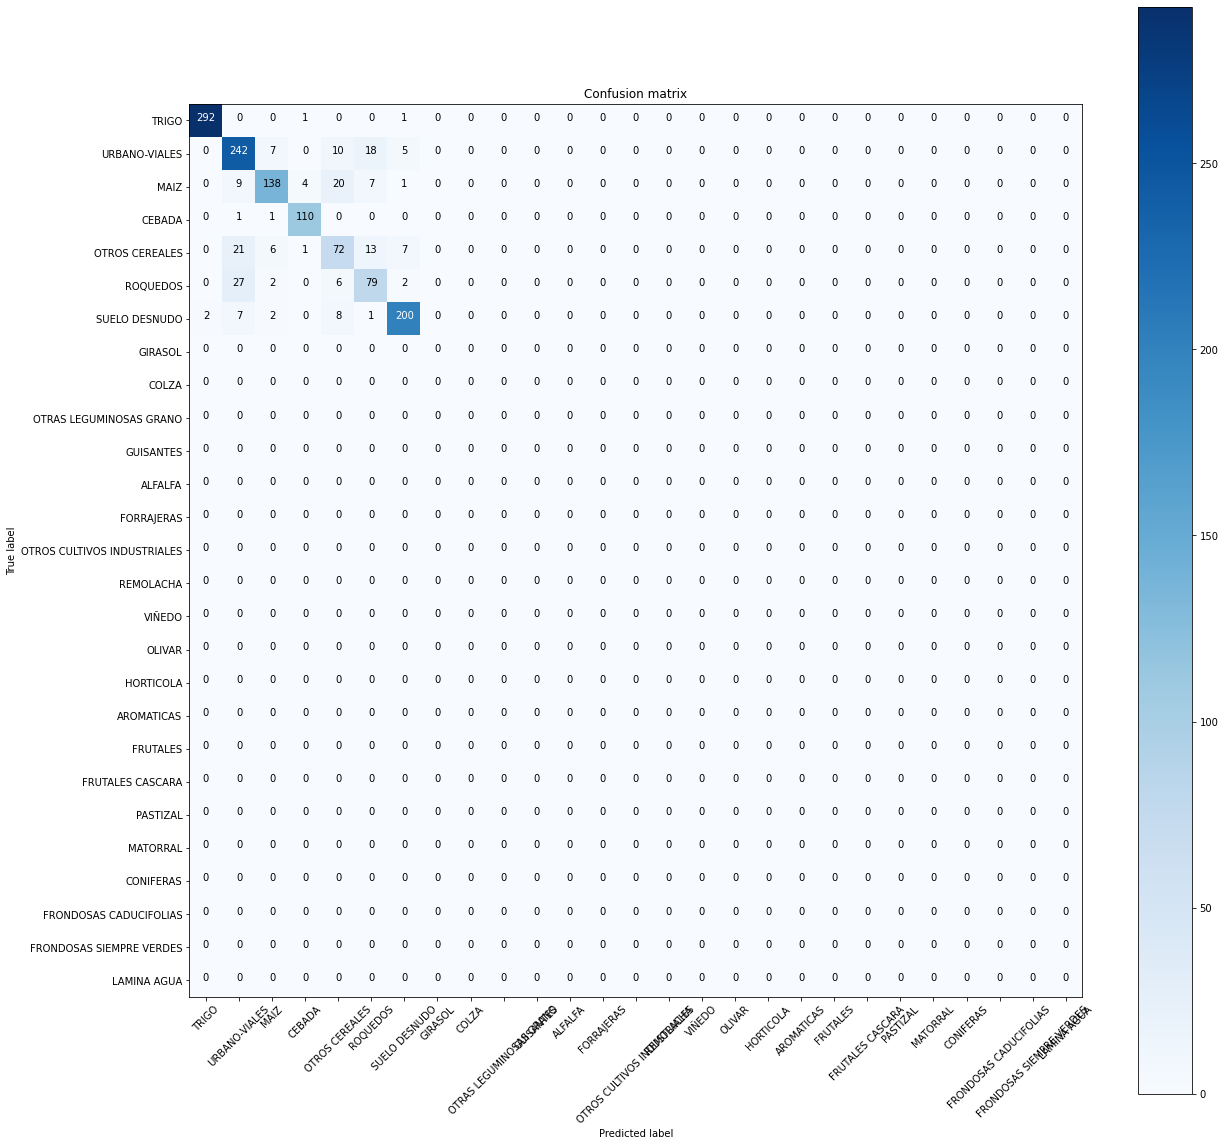

In [139]:
K.clear_session()

training_params = {
    'loss': f1_loss,
    'optimizer': 'rmsprop',
    'metrics': [f1],
    'run_eagerly': False
}

model.compile(**training_params)

epochs=100
exp_base = "conv1d"
folder = create_training_folder(exp_base, tag)

lr_scheduller = tf.keras.callbacks.LearningRateScheduler(step_decay_exp)
#lr_scheduller = tf.keras.callbacks.ReduceLROnPlateau(step_decay_exp)
lr_scheduller = None
callbacks = create_callbacks(folder, tensor_board=True, monitor_metric="val_f1", monitor_mode="max",
                     lr_scheduller=lr_scheduller)


train(model, X_train, y_train, X_test, y_test, epochs=epochs, callbacks=callbacks)

# save model
model_folder = '{}/model'.format(folder)
model.save(model_folder)

# evaluate
y_hat = model.predict(X_test)
eval_model_one_hot(folder, y_test, y_hat, crop_list, crop_names)


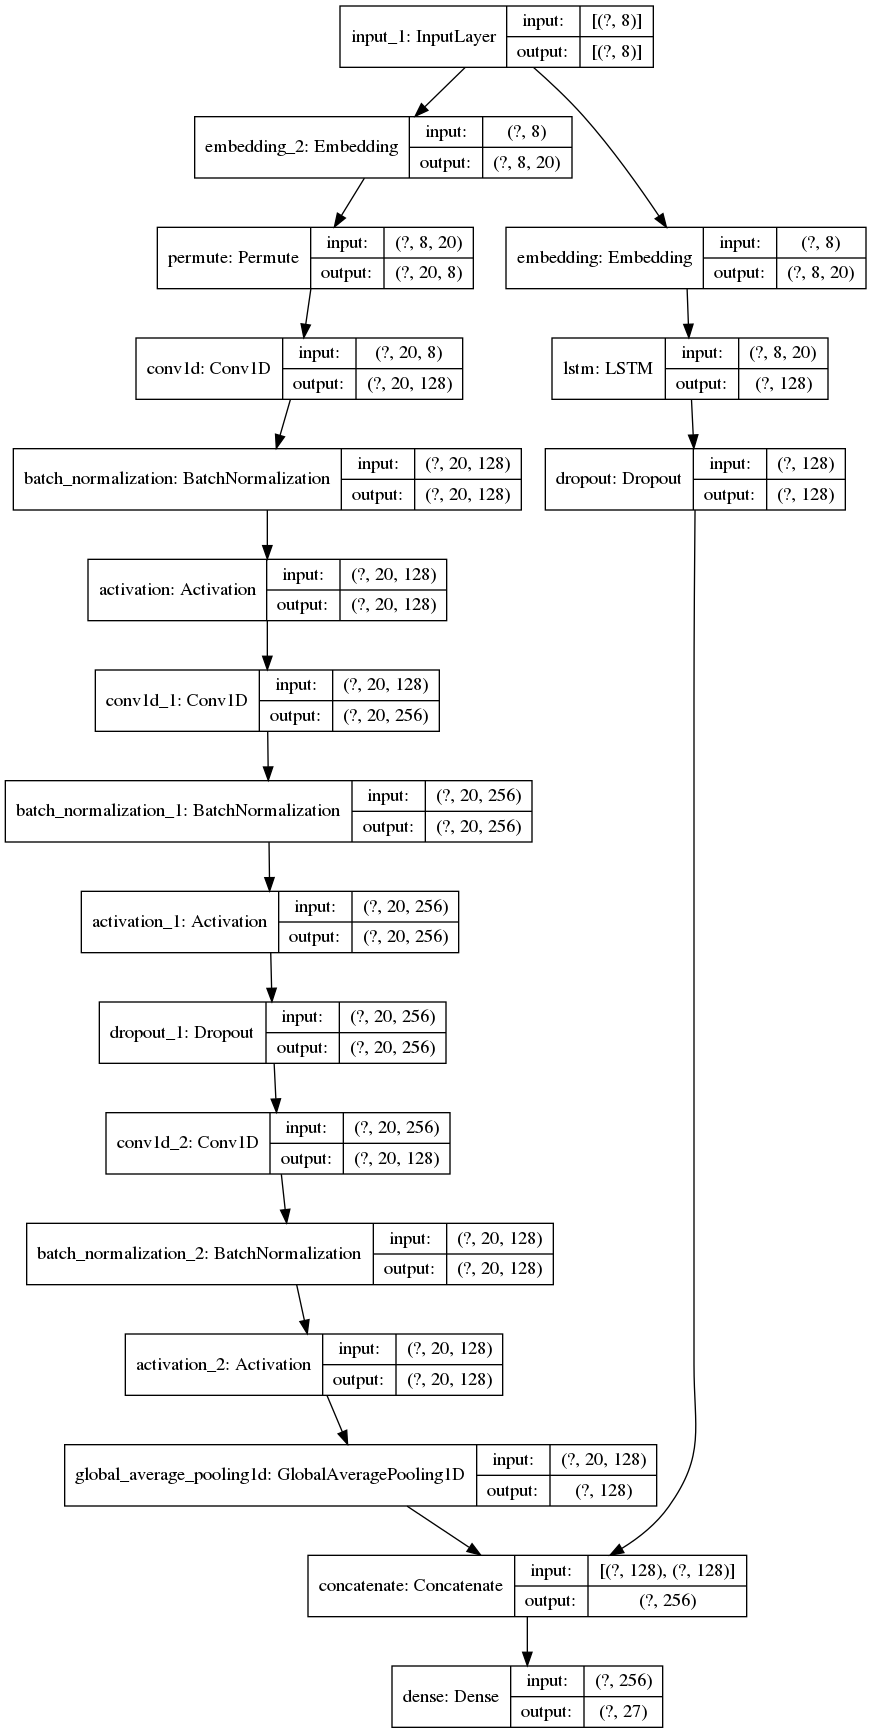

In [80]:
plot_model(model, show_shapes=True)

In [ ]:
eval_model_one_hot(folder, y_test, y_hat, crop_list, crop_names)